In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 

%matplotlib inline

## Part 0: Loading and cleaning the data

In [2]:
data_path = "CrowdstormingDataJuly1st.csv"
df = pd.read_csv(data_path)

**Each row in the dataset is a (player _p_, referee _r_) dyad containing some information about the player, total number of each type of card (yellow, yellow-red, and red) given by _r_ to _p_, and some statistics about racial bias in the referee's home country.**

In [3]:
df.sample(5)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
141251,garrido_2,Garrido,Norwich City,England,15.03.1985,178.0,75.0,Left Fullback,5,1,...,0.25,3012,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
127796,klaas-jan-huntelaar,Klaas-Jan Huntelaar,FC Schalke 04,Germany,12.08.1983,186.0,78.0,Center Forward,1,1,...,0.25,2743,52,RUS,0.398174,526.0,0.000809,1.212727,550.0,0.004521
95235,ronny-garbuschewski,Ronny Garbuschewski,Fortuna Düsseldorf,Germany,23.02.1986,178.0,75.0,Right Midfielder,2,1,...,0.25,2042,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225
32261,juanfran_2,Juanfran,Atlético Madrid,Spain,09.01.1985,180.0,72.0,Right Fullback,1,1,...,0.00,579,32,CHE,0.345305,1886.0,0.000219,0.377193,1938.0,0.000823
74881,billy-jones,Billy Jones,West Bromwich Albion,England,24.03.1987,180.0,83.0,Left Fullback,6,1,...,NaN,1633,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037


In [4]:
print("Number of entries: %d" % len(df))

Number of entries: 146028


**We want to make sure we do our analysis with a clean dataset, so we check for null entries**

In [5]:
df.isnull().sum()

playerShort          0
player               0
club                 0
leagueCountry        0
birthday             0
height             263
weight            2243
position         17726
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID          21407
rater1           21407
rater2           21407
refNum               0
refCountry           0
Alpha_3              1
meanIAT            163
nIAT               163
seIAT              163
meanExp            163
nExp               163
seExp              163
dtype: int64

**We can see that there are many players without skin color ratings. Those players aren't going to be useful for our prediction task, so we drop all of them**

In [6]:
df = df.dropna(subset=["rater1", "rater2"])
print(len(df))

124621


**What other missing values are we dealing with in this dataset?**
- Position: We see that of over 100,000 dyads there are several thousand rows missing the position field. We choose not to modify these values because we aren't going to use the player's position for our prediction.
- Height/weight and bias information for referee country: only a few hundred rows are missing this information, so we choose to drop all.

In [7]:
df = df.dropna(subset=['height', 'weight', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'])
df.isnull().sum()

playerShort         0
player              0
club                0
leagueCountry       0
birthday            0
height              0
weight              0
position         8258
games               0
victories           0
ties                0
defeats             0
goals               0
yellowCards         0
yellowReds          0
redCards            0
photoID             0
rater1              0
rater2              0
refNum              0
refCountry          0
Alpha_3             0
meanIAT             0
nIAT                0
seIAT               0
meanExp             0
nExp                0
seExp               0
dtype: int64

In [8]:
len(df)

123715

**OK, now we have a clean dataset to work with!**

**We read through the Crowdstorming analytics visualization notebook linked in the homework description. Unlike them, we decided that we do not have a strong reason to drop the dyads that they judged "incomplete" (i.e. did not have at least 11 referee-player dyads from the same club).**

**We decided to only work with the numeric features in the dataset, such as:
height, weight, game statistics, goals, cards, skin color ratings, and referee statistics.
We may be able to achieve better accuracy by encoding categorical features like the position and the country but for this assignment we chose to focus on playing with the classifier rather than going for maximum accuracy**

In [9]:
# How we apparently compute our features:
# Group by player, take the mean over the dyad
# This doesn't make much sense for total game stats,
# but the average number goals per game, cards per game, 
# and most importantly meanIAT and meanExp of the referees
# over all the player's games are useful
df_by_player = df.groupby("playerShort")
df_players = df_by_player.agg(np.mean)
df_players.head()

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
playerShort,,,,,,,,,,,,,,,,,,,,
aaron-hughes,182.0,71.0,3.939759,1.487952,1.078313,1.373494,0.054217,0.114458,0.000000,0.000000,0.25,0.00,1612.656627,43.921687,0.346459,19710.156627,0.000652,0.494575,20637.277108,0.004065
aaron-hunt,183.0,73.0,3.393939,1.424242,0.737374,1.232323,0.626263,0.424242,0.000000,0.010101,0.00,0.25,1662.515152,25.070707,0.348818,26104.292929,0.000219,0.449220,26864.454545,0.000993
aaron-lennon,165.0,63.0,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,0.000000,0.000000,0.25,0.25,1598.871287,42.772277,0.345893,21234.861386,0.000367,0.491482,22238.742574,0.002032
aaron-ramsey,178.0,76.0,2.500000,1.442308,0.403846,0.653846,0.375000,0.298077,0.000000,0.009615,0.00,0.00,1668.500000,45.067308,0.346821,38285.826923,0.003334,0.514693,39719.980769,0.013522
abdelhamid-el-kaoutari,180.0,73.0,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,0.108108,0.054054,0.25,0.25,1610.891892,17.189189,0.331600,2832.351351,0.001488,0.335587,2953.837838,0.005296


In [10]:
df_players.describe()


,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
count,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000
mean,182.042839,76.034527,2.903226,1.247609,0.704326,0.951291,0.310336,0.399730,0.012310,0.013003,0.267743,0.309783,1511.853989,26.711618,0.348415,16242.871908,0.000609,0.463617,16848.408464,0.002857
std,6.743169,7.105553,1.101581,0.527910,0.314797,0.433801,0.367279,0.285479,0.017776,0.017934,0.295731,0.296099,193.627225,14.044972,0.013425,26946.220220,0.001034,0.095542,27751.347852,0.004717
min,161.000000,54.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,705.500000,2.850000,0.268981,483.666667,0.000010,-0.108731,500.333333,0.000037
25%,178.000000,71.000000,2.073642,0.859649,0.492247,0.647680,0.063244,0.204983,0.000000,0.000000,0.000000,0.000000,1435.948236,14.146875,0.338500,3929.731061,0.000223,0.388103,4132.092366,0.001001
50%,182.000000,76.000000,2.782330,1.210443,0.658814,0.866667,0.186047,0.336499,0.000000,0.008231,0.250000,0.250000,1553.437099,27.270692,0.346405,7463.962994,0.000321,0.455258,7709.856676,0.001509
75%,187.000000,81.000000,3.573006,1.576882,0.881605,1.169802,0.432407,0.530938,0.018868,0.019802,0.500000,0.500000,1633.387070,38.828405,0.357850,22222.643116,0.000581,0.540415,23255.157737,0.002897
max,203.000000,100.000000,8.000000,3.657343,2.274510,3.450980,3.299145,2.482759,0.132075,0.166667,1.000000,1.000000,2960.000000,80.000000,0.413096,429801.926829,0.019879,1.122201,441869.926829,0.097267


In [11]:
# Create a df with player constant description attributes
df_players_description = pd.DataFrame(df_players[["height", "weight", "rater1", "rater2"]])
df_players_description.sample(5)
len(df_players_description)

1564

# Part 1: Random Forest

## Raters consistency

We suspect that the raters have a certain bias and do not always rate the same player the same way. We look at the differences

In [12]:
(df_players_description["rater1"] - df_players_description["rater2"]).describe()

count    1564.00000
mean       -0.04204
std         0.11639
min        -0.50000
25%         0.00000
50%         0.00000
75%         0.00000
max         0.25000
dtype: float64

We see that rater2 rates the skintone higher than rater1 on average. 
We now make a new attribute that is the mean of rater1 and rater2's scores. 

In [13]:
df_players_description["rateMean"] = (df_players_description["rater1"] + df_players_description["rater2"]) / 2

In [14]:
df_players_description.sample(5)

,height,weight,rater1,rater2,rateMean
playerShort,,,,,
jan-mucha,189.0,87.0,0.25,0.25,0.25
bruno-gama,175.0,68.0,0.25,0.25,0.25
marc-stendera,171.0,64.0,0.00,0.00,0.00
stephen-kelly,181.0,77.0,0.25,0.25,0.25
alassane-plea,180.0,65.0,0.75,0.75,0.75


Since random forest uses binary classification, we decided to define a binary attribute "darkSkin". We have to choose the limit between "white" and "black". We arbitrarily chose a mean rating greater than or equal to 0.5 to be considered "darkSkin".

In [15]:
df_players_description['darkSkin'] = df_players_description['rateMean']  >= 0.5
df_players_description.head(10)

,height,weight,rater1,rater2,rateMean,darkSkin
playerShort,,,,,,
aaron-hughes,182.0,71.0,0.25,0.00,0.125,False
aaron-hunt,183.0,73.0,0.00,0.25,0.125,False
aaron-lennon,165.0,63.0,0.25,0.25,0.250,False
aaron-ramsey,178.0,76.0,0.00,0.00,0.000,False
abdelhamid-el-kaoutari,180.0,73.0,0.25,0.25,0.250,False
abdou-traore_2,180.0,74.0,0.75,0.75,0.750,True
abdoulaye-diallo_2,189.0,80.0,0.75,1.00,0.875,True
abdoulaye-keita_2,188.0,83.0,0.75,1.00,0.875,True
abdoulwhaid-sissoko,180.0,68.0,1.00,1.00,1.000,True


In [16]:
print(df_players_description.isnull().sum())

height      0
weight      0
rater1      0
rater2      0
rateMean    0
darkSkin    0
dtype: int64


In [17]:
df_players_description =  df_players_description.dropna()

## Random forest machine learning

**First we train a RandomForestClassifier that given almost all of the features (except skin color ratings of course) outputs his skin color. We'll show that using the default settings it overfits to the training set, then try again with cross-validation**

In [18]:
df_players.head()
df_players['darkSkin'] = df_players_description['darkSkin']

X_all = df_players.drop(['rater1', 'rater2', 'darkSkin'], axis=1) # not in-place
y_all = df_players_description['darkSkin']


In [19]:
X_all.head()

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
playerShort,,,,,,,,,,,,,,,,,,
aaron-hughes,182.0,71.0,3.939759,1.487952,1.078313,1.373494,0.054217,0.114458,0.000000,0.000000,1612.656627,43.921687,0.346459,19710.156627,0.000652,0.494575,20637.277108,0.004065
aaron-hunt,183.0,73.0,3.393939,1.424242,0.737374,1.232323,0.626263,0.424242,0.000000,0.010101,1662.515152,25.070707,0.348818,26104.292929,0.000219,0.449220,26864.454545,0.000993
aaron-lennon,165.0,63.0,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,0.000000,0.000000,1598.871287,42.772277,0.345893,21234.861386,0.000367,0.491482,22238.742574,0.002032
aaron-ramsey,178.0,76.0,2.500000,1.442308,0.403846,0.653846,0.375000,0.298077,0.000000,0.009615,1668.500000,45.067308,0.346821,38285.826923,0.003334,0.514693,39719.980769,0.013522
abdelhamid-el-kaoutari,180.0,73.0,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,0.108108,0.054054,1610.891892,17.189189,0.331600,2832.351351,0.001488,0.335587,2953.837838,0.005296


In [20]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

def print_metrics(y, y_pred):
    # Print out some metrics judging the quality of the classification
    print("Accuracy:")
    print(metrics.accuracy_score(y, y_pred))
    print("F1: ")
    print(metrics.f1_score(y, y_pred))
    print("Confusion matrix:")
    print(metrics.confusion_matrix(y, y_pred))
    print("-------")

# Split the data into 60% of training set, and 40% of test set
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.4)

clf_all = RandomForestClassifier()
clf_all.fit(X_train, y_train)
y_pred_train = clf_all.predict(X_train)
y_pred_test = clf_all.predict(X_test)
print('Accuracy on training set is {0:.2f}%'.format(metrics.accuracy_score(y_train, y_pred_train)*100))
print_metrics(y_train, y_pred_train)
print('Accuracy on testing set is {0:.2f}%'.format(metrics.accuracy_score(y_test, y_pred_test)*100))
print_metrics(y_test, y_pred_test)

Accuracy on training set is 97.76%
Accuracy:
0.977611940299
F1: 
0.950118764846
Confusion matrix:
[[717   0]
 [ 21 200]]
-------
Accuracy on testing set is 78.59%
Accuracy:
0.785942492013
F1: 
0.390909090909
Confusion matrix:
[[449  20]
 [114  43]]
-------


**So, we obtain a nearly perfect classification accuracy on the training set but much worse on the test set. This isn't too surprising. With our small amount of data the random forest is likely overfitting to the jumble of numeric features we gave it. We will try reducing the maximum allowed height of the trees and see how the accuracy changes:**
- max_depth: parameter governing height of the trees

In [21]:
clf_shorter = RandomForestClassifier(max_depth=5)

clf_shorter.fit(X_train, y_train)
y_pred_train_shorter = clf_shorter.predict(X_train)
y_pred_test_shorter = clf_shorter.predict(X_test)

print('Accuracy on training set is {0:.2f}%'.format(metrics.accuracy_score(y_train, y_pred_train_shorter)*100))
print_metrics(y_train, y_pred_train_shorter)
print('Accuracy on testing set is {0:.2f}%'.format(metrics.accuracy_score(y_test, y_pred_test_shorter)*100))
print_metrics(y_test, y_pred_test_shorter)

Accuracy on training set is 83.69%
Accuracy:
0.836886993603
F1: 
0.49504950495
Confusion matrix:
[[710   7]
 [146  75]]
-------
Accuracy on testing set is 78.43%
Accuracy:
0.784345047923
F1: 
0.334975369458
Confusion matrix:
[[457  12]
 [123  34]]
-------


**When we only allow short trees (max_depth <= 5) in our random forest it seems like it changes the overfitting issue, s.**

**Next part: We start again with random forest, this time using cross validation.
Let's start with a simple model: considering only height and weight, try to obtain the player's skin color.**

In [22]:
X = df_players_description[['height', 'weight']]
y = df_players_description['darkSkin']
clf = RandomForestClassifier(n_estimators=100)

In [23]:
clf.fit(X,y)
y_pred = clf.predict(X)
print('The accuracy is {0:.2f}%'.format(metrics.accuracy_score(y, y_pred)*100))

The accuracy is 81.07%


  81% accuracy can seem pretty good, but we must remember that we are training on the whole dataset so it doesn't mean much. If we would try to predict on unseen data, the result would be poor as we are probably overfitting the training set. Now let's use cross-validation!

**Note: one example with train-test split**

In [24]:
from sklearn.cross_validation import train_test_split

# Split the data into 60% of training set, and 40% of test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('The accuracy is {0:.2f}%'.format(metrics.accuracy_score(y_test, y_pred)*100))

The accuracy is 68.85%


Training on 60% of the data gives around 70% accuracy. Let's try with a 20-fold cross validation.

In [25]:
from sklearn.cross_validation import cross_val_score

clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=20, scoring='accuracy')
pd.Series(scores).describe()

count    20.000000
mean      0.712868
std       0.033552
min       0.645570
25%       0.699051
50%       0.713405
75%       0.736530
max       0.759494
dtype: float64

Median score is 72%, and the standard deviation is not too high. That a decent score, considering that we are only looking at two features: height and weight. Let's try to add game features and see how the score changes.

In [26]:
df_players.head(5)

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,...,rater2,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,darkSkin
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,182.0,71.0,3.939759,1.487952,1.078313,1.373494,0.054217,0.114458,0.000000,0.000000,...,0.00,1612.656627,43.921687,0.346459,19710.156627,0.000652,0.494575,20637.277108,0.004065,False
aaron-hunt,183.0,73.0,3.393939,1.424242,0.737374,1.232323,0.626263,0.424242,0.000000,0.010101,...,0.25,1662.515152,25.070707,0.348818,26104.292929,0.000219,0.449220,26864.454545,0.000993,False
aaron-lennon,165.0,63.0,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,0.000000,0.000000,...,0.25,1598.871287,42.772277,0.345893,21234.861386,0.000367,0.491482,22238.742574,0.002032,False
aaron-ramsey,178.0,76.0,2.500000,1.442308,0.403846,0.653846,0.375000,0.298077,0.000000,0.009615,...,0.00,1668.500000,45.067308,0.346821,38285.826923,0.003334,0.514693,39719.980769,0.013522,False
abdelhamid-el-kaoutari,180.0,73.0,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,0.108108,0.054054,...,0.25,1610.891892,17.189189,0.331600,2832.351351,0.001488,0.335587,2953.837838,0.005296,False


In [27]:
def random_forest_scores(dataframe, features, target="darkSkin", estimators=100, folds=20):
    clf = RandomForestClassifier(n_estimators=estimators)
    X = dataframe[features]
    y = list(dataframe["darkSkin"].values)
    
    # Cross validation scores
    scores = cross_val_score(clf, X, y, cv=folds, scoring='accuracy')
    
    # Train again to get feature importances
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.4)
    clf.fit(X_train, y_train)
    
    return scores, clf.feature_importances_

In [28]:
df_players = df_players.dropna()

In [29]:
possible_features = ['height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']

In [30]:
scores, importances = random_forest_scores(df_players, possible_features)

In [31]:
pd.Series(scores).describe()

count    20.000000
mean      0.752565
std       0.023749
min       0.705128
25%       0.743590
50%       0.751623
75%       0.766983
max       0.794872
dtype: float64

Adding features adds around 3% of precision.

In [32]:
def plot_feature_importances(possible_features, importances):
    df_feature_importances = pd.DataFrame({"features": possible_features, "importances": importances})
    df_feature_importances = df_feature_importances.set_index("features")
    df_feature_importances = df_feature_importances.sort_values("importances", ascending=False)
    df_feature_importances.plot(kind="bar")

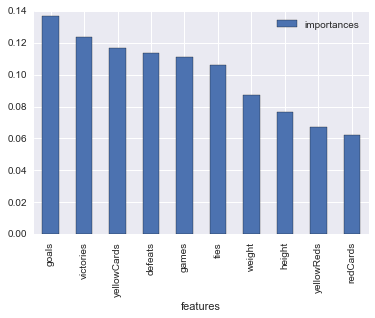

In [33]:
plot_feature_importances(possible_features, importances)

In [34]:
possible_features_2 = list(possible_features)
possible_features_2.remove("goals")

In [35]:
scores2, importances2 = random_forest_scores(df_players, possible_features_2)

In [36]:
pd.Series(scores2).describe()

count    20.000000
mean      0.751940
std       0.017803
min       0.708861
25%       0.743590
50%       0.756410
75%       0.766234
max       0.784810
dtype: float64

In [37]:
pd.Series(scores).describe()

count    20.000000
mean      0.752565
std       0.023749
min       0.705128
25%       0.743590
50%       0.751623
75%       0.766983
max       0.794872
dtype: float64

**Let's now try to incorporate the information about racial bias in each referee's country of origin.**

Previously we computed the average meanIAT and meanExp values for each player over all referee-player dyads. We again use the existing meanIAT and meanExp information from each dyad to create two new features for each player: stdIAT and stdExp. Note that this is not the same calculation as averaging the standard deviations _seIAT_ and _seExp_ from each dyad - on a high-level stdIAT and stdExp indicate the variance in referee nationalities (and potentially biases) over  all matches in which the player played.

This gives us four racial bias-related features:
- meanIAT = average of meanIAT values over all dyads containing the given player
- meanExp = average of meanExp values over all dyads containing the given player
- stdIAT = std deviation of meanIAT values over all dyads containing the given player. General idea: has this player been referee'd by a diverse group of referees?
- stdExp = std deviation of meanExp values over all dyads containing the given player

**We also computed a meanIAT_carded features, which is the average of meanIAT values over all dyads where the player received at least one card from that referee. But we commented it out because it didn't seem to work well**

In [38]:
#Not going to use this feature after all (meanIAT_carded)
#df['meanIAT_carded'] = df.apply(lambda x: x.meanIAT*(x.yellowCards+x.yellowReds+x.redCards), axis=1)
#df_players[['stdIAT','stdExp', 'stdIAT_carded']] = df_by_player['meanIAT', 'meanExp', 'meanIAT_carded'].agg(np.std)
df_players[['stdIAT','stdExp']] = df_by_player['meanIAT', 'meanExp'].agg(np.std)

**We check that our new standard deviation features were computed correctly**

In [39]:
df_players.sample(5)

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,...,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,darkSkin,stdIAT,stdExp
playerShort,,,,,,,,,,,,,,,,,,,,,
dani-estrada,179.0,74.0,3.250000,1.300000,0.825000,1.125000,0.075000,0.650000,0.050000,0.000000,...,6.075000,0.367864,1716.750000,0.000273,0.591116,1824.225000,0.001194,False,0.015485,0.050200
fabio-coentrao,179.0,70.0,2.469388,1.520408,0.387755,0.561224,0.163265,0.520408,0.051020,0.010204,...,43.469388,0.367707,25214.183673,0.000408,0.605686,25998.081633,0.001919,False,0.028527,0.206101
kalilou-traore,192.0,76.0,1.816667,0.650000,0.383333,0.783333,0.216667,0.450000,0.033333,0.016667,...,42.200000,0.336878,3672.166667,0.003467,0.414488,3828.800000,0.013445,True,0.071035,0.419451
paco-alcacer,174.0,71.0,1.790698,0.790698,0.511628,0.488372,0.558140,0.162791,0.000000,0.000000,...,24.790698,0.354884,4901.069767,0.001373,0.538454,5140.511628,0.005777,False,0.047627,0.232959
nene_2,181.0,70.0,3.073394,1.211009,0.788991,1.073394,0.825688,0.376147,0.009174,0.009174,...,27.761468,0.352273,4975.816514,0.000604,0.477288,5215.467890,0.003362,False,0.024150,0.157595


In [40]:
df_players[df_players['stdExp'].isnull()]#.sum()

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,...,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,darkSkin,stdIAT,stdExp
playerShort,,,,,,,,,,,,,,,,,,,,,
baptiste-aloe,184.0,77.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,80.0,0.396512,2273.0,0.000187,1.031407,2388.0,0.000931,False,NaN,NaN
charlie-took,184.0,78.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,True,NaN,NaN
kevin-osei,173.0,71.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,57.0,0.337539,1319.0,0.000331,0.394139,1365.0,0.001717,True,NaN,NaN


In [41]:
df_players[df_players['stdIAT'].isnull()]#.sum()

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,...,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,darkSkin,stdIAT,stdExp
playerShort,,,,,,,,,,,,,,,,,,,,,
baptiste-aloe,184.0,77.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,80.0,0.396512,2273.0,0.000187,1.031407,2388.0,0.000931,False,NaN,NaN
charlie-took,184.0,78.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,True,NaN,NaN
kevin-osei,173.0,71.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,57.0,0.337539,1319.0,0.000331,0.394139,1365.0,0.001717,True,NaN,NaN


**We can see that there are some NaN values so we replace them with 0**

In [42]:
df_players.replace(to_replace={'stdIAT': {np.nan : 0}, 'stdExp': {np.nan : 0}, 'stdIAT_carded': {np.nan : 0}}, inplace=True)

In [43]:
#possible_features_with_bias = ['stdIAT_carded', 'meanIAT_carded', 'meanIAT', 'stdIAT', 'meanExp', 'stdExp', 'height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']
possible_features_with_bias = ['meanIAT', 'stdIAT', 'meanExp', 'stdExp', 'height', 'weight', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']

In [44]:
scores_bias, importances_bias = random_forest_scores(df_players, possible_features_with_bias)

In [45]:
pd.Series(scores_bias).describe()

count    20.000000
mean      0.794866
std       0.047078
min       0.708861
25%       0.758723
50%       0.796170
75%       0.825422
max       0.884615
dtype: float64

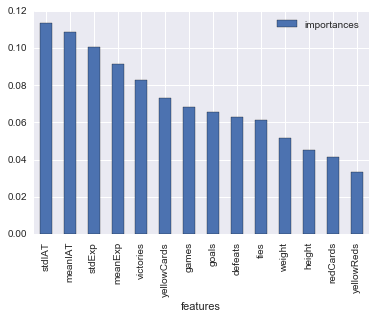

In [46]:
plot_feature_importances(possible_features_with_bias, importances_bias)

**When we include the features relating to the racial bias in referee countries, we see a bump of several percent in accuracy, up to 78-79%. These features are ranked highly in importance so they seem to be quite important to the prediction!**

# Part 2: Clustering

We choose KMeans as clustering algorithm as it is the simplest.

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

We use the features corresponding to national racial bias in the referee's home countries, since in part 1 we found these to be predictive of skin color.

In [48]:
bias_features = ['meanIAT', 'stdIAT', 'meanExp', 'stdExp']

In [49]:
X = df_players[bias_features]

We run KMeans with the default k-means++ initialization strategy. We're looking for two clusters corresponding to dark skinned and light skinned players respectively.

In [50]:
kmeans = KMeans(n_clusters=2).fit(X)
cluster_indexes = kmeans.predict(X)

In [51]:
cluster1 = df_players.loc[cluster_indexes == 0]
cluster2 = df_players.loc[cluster_indexes == 1]

def dark_skin_proportion(cluster):
    """Return the proportion of dark skin player in the cluster"""
    return cluster['darkSkin'].sum() / len(cluster)

In [52]:
print(dark_skin_proportion(cluster1), dark_skin_proportion(cluster2))

0.168289290682 0.304142011834


In [53]:
def cluster_dark_separator_score(cluster1, cluster2):
    """Returns a heuristic that gives a score between 0 and 1 to the cluster assignment.
    The higher the score, the more the clusters separate players by skin colors"""
    return np.abs(dark_skin_proportion(cluster1) - dark_skin_proportion(cluster2))

In [54]:
cluster_dark_separator_score(cluster1, cluster2)

0.13585272115281746

In [55]:
def kmean_dark_separator_score(X):
    """Given a dataset, returns heuristic score and silhouette score for the
    clusters generated by KMeans"""
    kmeans = KMeans(n_clusters=2).fit(X)
    cluster_indexes = kmeans.predict(X)
    cluster1 = df_players.loc[cluster_indexes == 0]
    cluster2 = df_players.loc[cluster_indexes == 1]
    
    
    return cluster_dark_separator_score(cluster1, cluster2), silhouette_score(X, cluster_indexes)

### Maximize score

Let's look at all 1-feature cases

In [56]:
feature_score_silhouette = []

for feature in possible_features_with_bias:
    score, silhouette = kmean_dark_separator_score(df_players[[feature]])
    feature_score_silhouette.append((feature, score, silhouette))

We can see that for the 1-feature case, the silhouette is always between 0.5-0.75 which is quite good. We thus order by the score they give when they are used alone in KMeans.

In [57]:
feature_score_silhouette = sorted(feature_score_silhouette, key=lambda x:x[1])
["Feature: {:12} Score: {:.2f}    Silhouette: {:.2f}".format(feature, score, silhouette) 
     for feature, score, silhouette in reversed(feature_score_silhouette)]

['Feature: stdIAT       Score: 0.27    Silhouette: 0.59',
 'Feature: meanIAT      Score: 0.14    Silhouette: 0.61',
 'Feature: meanExp      Score: 0.13    Silhouette: 0.61',
 'Feature: yellowCards  Score: 0.12    Silhouette: 0.62',
 'Feature: stdExp       Score: 0.11    Silhouette: 0.53',
 'Feature: games        Score: 0.09    Silhouette: 0.56',
 'Feature: defeats      Score: 0.09    Silhouette: 0.60',
 'Feature: victories    Score: 0.08    Silhouette: 0.56',
 'Feature: goals        Score: 0.06    Silhouette: 0.70',
 'Feature: height       Score: 0.06    Silhouette: 0.58',
 'Feature: weight       Score: 0.05    Silhouette: 0.56',
 'Feature: redCards     Score: 0.04    Silhouette: 0.70',
 'Feature: ties         Score: 0.03    Silhouette: 0.59',
 'Feature: yellowReds   Score: 0.03    Silhouette: 0.71']

We order the features by score they give as a single KMean feature

In [58]:
ordered_features = [fscore[0] for fscore in feature_score_silhouette]
",".join(ordered_features)

'yellowReds,ties,redCards,weight,height,goals,victories,defeats,games,stdExp,yellowCards,meanExp,meanIAT,stdIAT'

We remove each feature iteratively and print the resulting heuristic score and silhouette score

In [59]:
# Remove each feature iteratively
for i in range(len(ordered_features)):
    score, silhouette = kmean_dark_separator_score(df_players[ordered_features[i:]])
    
    print('Before removing {:12} score is {:.02f}  silhouette is {:.02f}'.format(ordered_features[i], score, silhouette))

Before removing yellowReds   score is 0.04  silhouette is 0.46
Before removing ties         score is 0.04  silhouette is 0.46
Before removing redCards     score is 0.04  silhouette is 0.46
Before removing weight       score is 0.04  silhouette is 0.46
Before removing height       score is 0.06  silhouette is 0.53
Before removing goals        score is 0.08  silhouette is 0.44
Before removing victories    score is 0.08  silhouette is 0.47
Before removing defeats      score is 0.09  silhouette is 0.49
Before removing games        score is 0.09  silhouette is 0.51
Before removing stdExp       score is 0.12  silhouette is 0.50
Before removing yellowCards  score is 0.12  silhouette is 0.55
Before removing meanExp      score is 0.14  silhouette is 0.58
Before removing meanIAT      score is 0.50  silhouette is 0.55
Before removing stdIAT       score is 0.27  silhouette is 0.59


We see that keeping only `["meanIAT", "stdIAT"]` is optimal

In [60]:
X = df_players[["meanIAT", "stdIAT"]]
kmeans = KMeans(n_clusters=2).fit(X)
cluster_indexes = kmeans.predict(X)
cluster1 = df_players.loc[cluster_indexes == 0]
cluster2 = df_players.loc[cluster_indexes == 1]

FMT = "Cluster {}: {:.2f}% of dark skin players"
print(FMT.format(1, 100 * dark_skin_proportion(cluster1)))
print(FMT.format(2, 100 * dark_skin_proportion(cluster2)))

Cluster 1: 70.23% of dark skin players
Cluster 2: 19.96% of dark skin players


We see the clustering works decently, one cluster contains **a vast majority of dark skin players** while the other contains a **vast majority of light skin players**.

Also, the silhouette score is good.

In [61]:
"Silhouette score: {:.2f}".format(silhouette_score(X, cluster_indexes))

'Silhouette score: 0.55'

**We thus find that using features `["meanIAT", "stdIAT"]` gives two clusters with good silhouette score, and separates quite well dark-skin and light-skin players**